# seance 2 : oscilloscope

## etape 0 : connection à l'osci

In [1]:
import pyvisa

rm = pyvisa.ResourceManager()   # ou '@py' si tu utilises pyvisa-py
resources = rm.list_resources()
print("Ressources trouvées :", resources)


Ressources trouvées : ('USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')


In [7]:
import pyvisa

# 1) ID de l’oscilloscope 
OSCI_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"

# 2) Connexion VISA
rm = pyvisa.ResourceManager()
osci = rm.open_resource(OSCI_ID)

# (optionnel) pour voir si la com marche bien
print("IDN:", osci.query("*IDN?"))

# 3) Choisir la source de mesure (CHAN1 ou CHAN2)
#   Comme dans le syllabus : :MEAS:SOUR:CHAN2
osci.write(":MEAS:SOUR CHAN1")  # ici on choisit CHAN1, change si besoin

# 4) Lecture de quelques grandeurs
# Selon le modèle, soit la syntaxe est :MEAS:ITEM? VPP
# soit :MEAS:VPP? CHAN1. Ici on part sur la version du syllabus.
raw_vpp  = osci.query(":MEAS:ITEM? VPP")
raw_vavg = osci.query(":MEAS:ITEM? VAVG")
raw_per  = osci.query(":MEAS:ITEM? PER")

# Si ton oscillo accepte VRMS via ITEM :
try:
    raw_vrms = osci.query(":MEAS:ITEM? VRMS")
except Exception as e:
    print("VRMS via :MEAS:ITEM? ne passe pas, on ignore pour l’instant :", e)
    raw_vrms = None

print("Brut :")
print("VPP  =", repr(raw_vpp))
print("VAVG =", repr(raw_vavg))
print("PER  =", repr(raw_per))
print("VRMS =", repr(raw_vrms))

# 5) Conversion en float (en nettoyant bien la chaine)
def to_float(value):
    if value is None:
        return None
    # remove whitespace + \n etc.
    value = value.strip()
    # Certains appareils renvoient "9.123E+00" ou "VPP,9.123"
    # Si virgules -> on prend le dernier bout
    if "," in value:
        value = value.split(",")[-1]
    return float(value)

vpp  = to_float(raw_vpp)
vavg = to_float(raw_vavg)
per  = to_float(raw_per)
vrms = to_float(raw_vrms) if raw_vrms is not None else None

print("\nConverti en float :")
print("VPP  =", vpp)
print("VAVG =", vavg)
print("PER  =", per)
print("VRMS =", vrms)

#  Nettoyage
osci.close()
rm.close()


IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301111,00.04.04.SP4

Brut :
VPP  = '1.048000e+01\n'
VAVG = '-3.311035e-02\n'
PER  = '1.000000e-03\n'
VRMS = '3.452262e+00\n'

Converti en float :
VPP  = 10.48
VAVG = -0.03311035
PER  = 0.001
VRMS = 3.452262


In [8]:
import pyvisa
rm = pyvisa.ResourceManager()
Osci = rm.open_resource("USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR")
# To select a single channel (1 or 2) permanently you can use this line
# it allows you to not write CHAN2 at every call
Osci.write(':MEAS:SOUR:CHAN2')
data = []
data.append(Osci.query(':MEAS:Item? VPP'))
data.append(Osci.query(':MEAS:Item? VAVG'))
data.append(Osci.query(':MEAS:Item? PER'))
data.append(Osci.query(':MEAS:SOUR?'))
data.append(Osci.query(':CHAN1:SCAL?'))
data.append(Osci.query(':FUNC:WREC:FEND?'))
Osci.write(':MATH:FFT:SOUR CHAN1')
Osci.write(':MATH:OPER FFT')
Osci.write(':MATH:DISP ON')
data.append(Osci.query(':LAN:VISA?'))
# Warning to Measure 'MAth' should be off
# either it might not work, try it yourself! do you get data 8?
Osci.write(':MATH:OPER FFT')
Osci.write(':MATH:DISP OFF')
#measure the frequency of the signal
Osci.write(':MEAS:COUN:SOUR CHAN1')
data.append(Osci.query(':MEAS:COUN:VAL?'))
print(data)

['1.064000e+01\n', '-3.357849e-02\n', '1.000000e-03\n', 'CHAN1\n', '2.000000e+00\n', '26\n', 'TCPIP::141.1.168.192::INSTR\n', '1.0000163e+03\n']


# etape 2 : faire un graphe VRMS(t) correct et stable 


Mesure 1/10 : VRMS = 3.44303 V
Mesure 2/10 : VRMS = 3.44565 V
Mesure 3/10 : VRMS = 3.44395 V
Mesure 4/10 : VRMS = 3.44286 V
Mesure 5/10 : VRMS = 3.44495 V
Mesure 6/10 : VRMS = 3.44362 V
Mesure 7/10 : VRMS = 3.44354 V
Mesure 8/10 : VRMS = 3.44413 V
Mesure 9/10 : VRMS = 3.44292 V
Mesure 10/10 : VRMS = 3.44699 V
Moyenne VRMS (10 mesures) = 3.4441640999999996
Mesure 1/100 : VRMS = 3.44437 V
Mesure 2/100 : VRMS = 3.44291 V
Mesure 3/100 : VRMS = 3.44483 V
Mesure 4/100 : VRMS = 3.44359 V
Mesure 5/100 : VRMS = 3.44535 V
Mesure 6/100 : VRMS = 3.44427 V
Mesure 7/100 : VRMS = 3.44417 V
Mesure 8/100 : VRMS = 3.44413 V
Mesure 9/100 : VRMS = 3.44530 V
Mesure 10/100 : VRMS = 3.44346 V
Mesure 11/100 : VRMS = 3.44466 V
Mesure 12/100 : VRMS = 3.44573 V
Mesure 13/100 : VRMS = 3.44500 V
Mesure 14/100 : VRMS = 3.44521 V
Mesure 15/100 : VRMS = 3.44349 V
Mesure 16/100 : VRMS = 3.44427 V
Mesure 17/100 : VRMS = 3.44501 V
Mesure 18/100 : VRMS = 3.44316 V
Mesure 19/100 : VRMS = 3.44513 V
Mesure 20/100 : VRMS = 3

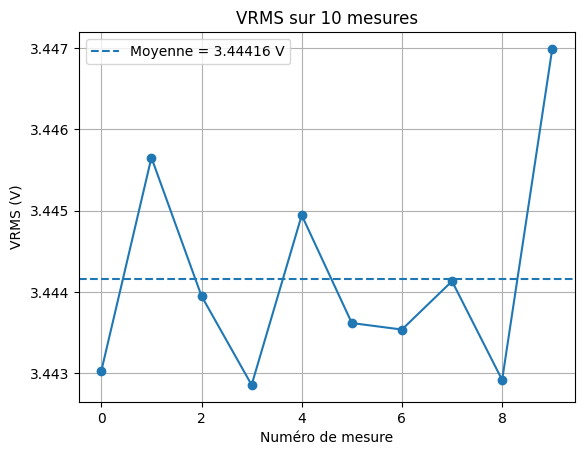

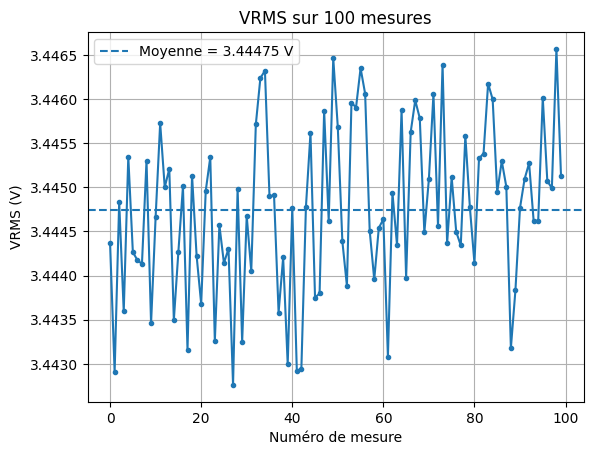

In [21]:
import pyvisa
import time
import numpy as np
import matplotlib.pyplot as plt

OSCI_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"

rm = pyvisa.ResourceManager()
osci = rm.open_resource(OSCI_ID)

osci.write(":MEAS:SOUR CHAN1")   # canal où tu mesures ton sinus

def get_vrms():
    raw = osci.query(":MEAS:ITEM? VRMS").strip()
    if "," in raw:
        raw = raw.split(",")[-1]
    return float(raw)

def mesure_vrms_plusieurs_fois(N, delay_s):
    vals = []
    for k in range(N):
        v = get_vrms()
        vals.append(v)
        print(f"Mesure {k+1}/{N} : VRMS = {v:.5f} V")
        time.sleep(delay_s)   # 500 ms entre deux mesures
    return np.array(vals)

# === 1) 10 mesures avec 500 ms entre chaque ===
vrms_10 = mesure_vrms_plusieurs_fois(10, 0.5)
moy_10 = vrms_10.mean()
print("Moyenne VRMS (10 mesures) =", moy_10)

plt.figure()
plt.plot(vrms_10, marker="o")
plt.axhline(moy_10, linestyle="--", label=f"Moyenne = {moy_10:.5f} V")
plt.xlabel("Numéro de mesure")
plt.ylabel("VRMS (V)")
plt.title("VRMS sur 10 mesures")
plt.grid()
plt.legend()

# === 2) 100 mesures avec 500 ms entre chaque ===
vrms_100 = mesure_vrms_plusieurs_fois(100, 0.5)
moy_100 = vrms_100.mean()
print("Moyenne VRMS (100 mesures) =", moy_100)

plt.figure()
plt.plot(vrms_100, marker=".")
plt.axhline(moy_100, linestyle="--", label=f"Moyenne = {moy_100:.5f} V")
plt.xlabel("Numéro de mesure")
plt.ylabel("VRMS (V)")
plt.title("VRMS sur 100 mesures")
plt.grid()
plt.legend()

plt.show()

osci.close()
rm.close()


In [35]:
import pyvisa
import time
import numpy as np

OSCI_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"

rm = pyvisa.ResourceManager()
osci = rm.open_resource(OSCI_ID)

osci.write(":MEAS:SOUR CHAN1")   # canal du sinus

def get_vrms():
    raw = osci.query(":MEAS:ITEM? VRMS").strip()
    if "," in raw:
        raw = raw.split(",")[-1]
    return float(raw)

def test_delay(delay_s, N=50):
    times = []
    values = []
    print(f"\n=== Test delay = {delay_s} s ===")
    t0 = time.time()
    for k in range(N):
        t_now = time.time()
        v = get_vrms()
        times.append(t_now)
        values.append(v)
        time.sleep(delay_s)
    times = np.array(times)
    values = np.array(values)

    # intervalle moyen entre deux mesures
    dt = np.diff(times)
    dt_mean = dt.mean()
    f_sample = 1.0 / dt_mean

    print(f"dt moyen ≈ {dt_mean:.4f} s  ->  f_echant ≈ {f_sample:.2f} Hz")
    print(f"VRMS min = {values.min():.5f}, max = {values.max():.5f}")
    return dt_mean, f_sample, values

delays = [0.5, 0.2, 0.1, 0.05, 0.02, 0.01]

results = {}
for d in delays:
    dt_mean, f_sample, vals = test_delay(d)
    results[d] = (dt_mean, f_sample, vals)

osci.close()
rm.close()



=== Test delay = 0.5 s ===
dt moyen ≈ 0.5036 s  ->  f_echant ≈ 1.99 Hz
VRMS min = 0.34576, max = 0.34630

=== Test delay = 0.2 s ===
dt moyen ≈ 0.2034 s  ->  f_echant ≈ 4.92 Hz
VRMS min = 0.34588, max = 0.34624

=== Test delay = 0.1 s ===
dt moyen ≈ 0.1039 s  ->  f_echant ≈ 9.62 Hz
VRMS min = 0.34591, max = 0.34614

=== Test delay = 0.05 s ===
dt moyen ≈ 0.0534 s  ->  f_echant ≈ 18.74 Hz
VRMS min = 0.34598, max = 0.34613

=== Test delay = 0.02 s ===
dt moyen ≈ 0.0254 s  ->  f_echant ≈ 39.30 Hz
VRMS min = 0.34598, max = 0.34611

=== Test delay = 0.01 s ===
dt moyen ≈ 0.0208 s  ->  f_echant ≈ 48.07 Hz
VRMS min = 0.34601, max = 0.34611


IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301111,00.04.04.SP4

PREamble: 2,0,1200,1,2.000000e-06,-1.200000e-03,0,8.000000e-02,0,127
Points attendus : 1200
Points réellement lus : 1200
t[0:5] = [-0.0012   -0.001198 -0.001196 -0.001194 -0.001192]
v[0:5] = [-10.5632004 -10.5312004 -10.5632004 -10.5312004 -10.5568004]


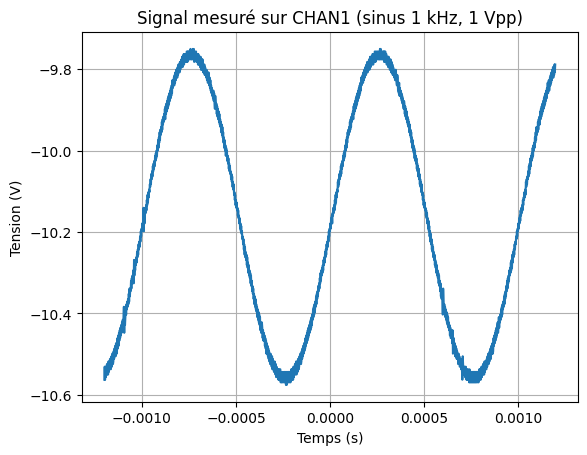

In [19]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

OSCI_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"

# ===========================
#  Connexion
# ===========================
rm = pyvisa.ResourceManager()
scope = rm.open_resource(OSCI_ID)

scope.timeout = 5000  # 5 s au cas où
scope.encoding = "ascii"

print("IDN:", scope.query("*IDN?"))

# ===========================
#  Config waveform
# ===========================
# On fige l'affichage pour avoir une trace stable
scope.write(":STOP")

# Source = CHAN1 (change en CHAN2 plus tard pour la sortie LM741)
scope.write(":WAV:SOUR CHAN1")

# Mode normal, format ASCII pour début (plus simple à debugger)
scope.write(":WAV:MODE NORM")
scope.write(":WAV:FORM ASC")

# ===========================
#  Lecture du préambule
# ===========================
preamble = scope.query(":WAV:PRE?").strip()
print("PREamble:", preamble)

# Le préambule RIGOL DS1000Z renvoie 10 champs :
# FORMAT, TYPE, POINTS, COUNT, XINC, XORIG, XREF, YINC, YORIG, YREF
params = preamble.split(",")

fmt    = int(params[0])   # on ne s'en sert pas ici
wtype  = int(params[1])
points = int(params[2])
count  = int(params[3])
xinc   = float(params[4])
xorig  = float(params[5])
xref   = float(params[6])
yinc   = float(params[7])
yorig  = float(params[8])
yref   = float(params[9])

print(f"Points attendus : {points}")

# ===========================
#  Lecture des données
# ===========================
raw = scope.query(":WAV:DATA?")

# Si la réponse commence par un bloc #nxxxxx..., on enlève l'en-tête
if raw.startswith("#"):
    ndigits = int(raw[1])                     # ex: '9'
    nbytes  = int(raw[2:2+ndigits])           # ex: '000016208' -> 16208
    data_start = 2 + ndigits
    data_end   = data_start + nbytes
    raw_data = raw[data_start:data_end]
else:
    raw_data = raw

raw_values = [v for v in raw_data.split(",") if v.strip() != ""]
y_raw = np.array([float(v) for v in raw_values])

print(f"Points réellement lus : {len(y_raw)}")


# ===========================
#  Reconstruction temps + tension
# ===========================
# Formules du manuel RIGOL :
#   X(i) = ( (i - XREF) * XINC ) + XORIG
#   Y(i) = ( (ADCDATA(i) - YREF) * YINC ) + YORIG

i = np.arange(len(y_raw))
t = (i - xref) * xinc + xorig
v = (y_raw - yref) * yinc + yorig

# Affichage de quelques valeurs pour vérifier
print("t[0:5] =", t[0:5])
print("v[0:5] =", v[0:5])

# ===========================
#  Tracé
# ===========================
plt.figure()
plt.plot(t, v)
plt.xlabel("Temps (s)")
plt.ylabel("Tension (V)")
plt.title("Signal mesuré sur CHAN1 (sinus 1 kHz, 1 Vpp)")
plt.grid()
plt.show()

# On relance l'acquisition normale sur l'oscillo
scope.write(":RUN")

scope.close()
rm.close()


RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301111,00.04.04.SP4

2,0,1200,1,2.000000e-06,-1.200000e-03,0,8.000000e-03,0,127



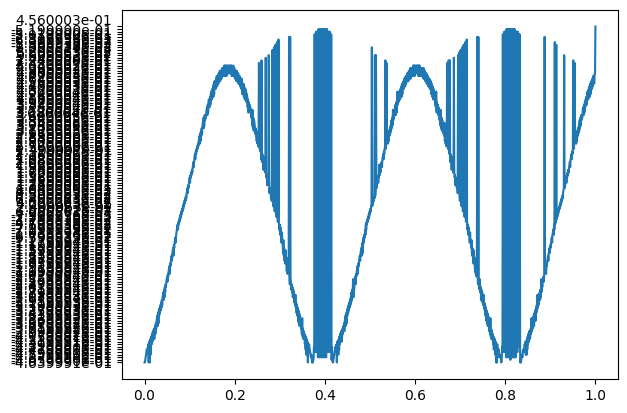

In [34]:
import pyvisa
import numpy as n
import matplotlib.pyplot as mp
#Create a resource manager

resources = pyvisa.ResourceManager()
#Open the Rigol by name. (Change this to the string for your instrument)
osc = resources.open_resource("USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR")
#Return the Rigol's ID string to tell us it's there
print(osc.query('*IDN?'))
# reading procedure initialisation
osc.write(':WAVeform:FORMat ASCII') #easy to read information but slower
osc.write(':WAVeform:Mode NORMAL') #see programming book
L1 = osc.query(':WAVeform:PREamble?') #to know everything
print(L1)
osc.write(':WAVform:SOURce Channel1')
D1 = osc.query(':WAVEFORM:DATA?')
D2 = D1.split(',')
Lgth = n.size(D2)
mp.plot(n.linspace(0,1,Lgth-1),D2[1:Lgth])

RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301111,00.04.04.SP4

2,0,1200,1,2.000000e-06,-1.200000e-03,0,8.000000e-02,0,127



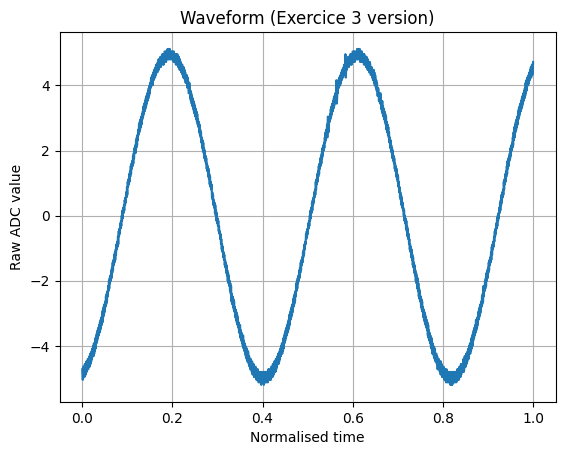

In [26]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

rm = pyvisa.ResourceManager()
osc = rm.open_resource("USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR")

print(osc.query("*IDN?"))

# paramétrage comme dans l'exo
osc.write(":WAV:FORM ASCII")
osc.write(":WAV:MODE NORM")
osc.write(":WAV:SOUR CHAN1")

# PREAMBLE
preamble = osc.query(":WAV:PRE?")
print(preamble)

# waveform brute
raw = osc.query(":WAV:DATA?")

# ==============================
# correction indispensable pour block format #9xxxxxx
# ==============================
if raw.startswith("#"):
    ndigits = int(raw[1])
    nbytes = int(raw[2:2+ndigits])
    data_start = 2 + ndigits
    raw = raw[data_start:data_start+nbytes]

# séparation
D2 = raw.split(',')
Lgth = len(D2)

# conversion en float
Y = np.array([float(v) for v in D2 if v.strip() != ""])

# tracé comme dans l'exo
plt.plot(np.linspace(0, 1, len(Y)), Y)
plt.xlabel("Normalised time")
plt.ylabel("Raw ADC value")
plt.title("Waveform (Exercice 3 version)")
plt.grid()
plt.show()

osc.close()
rm.close()


# Exo3 : mesure d'onde 

RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301111,00.04.04.SP4

PREAMBLE = 2,0,1200,1,2.000000e-06,-1.200000e-03,0,8.000000e-03,0,127



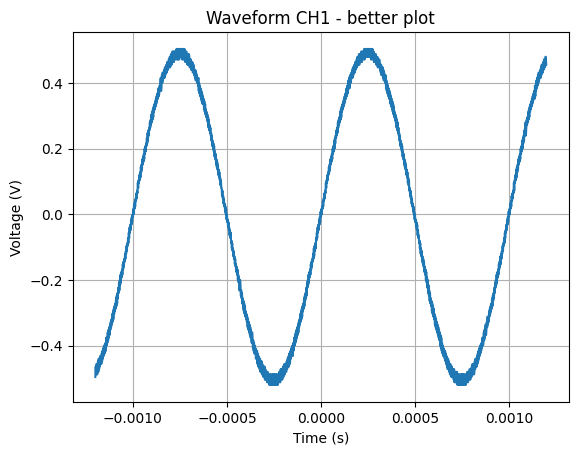

In [33]:
import pyvisa
import numpy as np
import matplotlib.pyplot as mp

rm = pyvisa.ResourceManager()
osc = rm.open_resource("USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR")

print(osc.query("*IDN?"))

osc.write(":WAV:FORM ASCII")
osc.write(":WAV:MODE NORM")
osc.write(":WAV:SOUR CHAN1")

# PREAMBLE
L1 = osc.query(":WAV:PRE?")
print("PREAMBLE =", L1)
p = L1.split(",")
xinc  = float(p[4])
xorig = float(p[5])
xref  = float(p[6])

# DATA brute
D1 = osc.query(":WAV:DATA?")

# ---- en-tête #9xxxxx à enlever ----
if D1.startswith("#"):
    nd = int(D1[1])
    nb = int(D1[2:2+nd])
    start = 2 + nd
    D1_clean = D1[start:start+nb]
else:
    D1_clean = D1

D2 = [v for v in D1_clean.split(",") if v.strip() != ""]
Y = np.array([float(v) for v in D2])
N = len(Y)

# axe temps correct (en secondes)
i = np.arange(N)
T = (i - xref) * xinc + xorig

mp.figure()
mp.plot(T, Y)
mp.xlabel("Time (s)")
mp.ylabel("Voltage (V)")
mp.title("Waveform CH1 - better plot")
mp.grid()
mp.show()

osc.close()
rm.close()



# Exo4 : mesure de phase (dephasage)

IDN: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301111,00.04.04.SP4

t_peak1 = 225.00 µs
t_peak2 = 370.00 µs
Δt      = 145.00 µs
Phase mesurée ≈ 52.20°  (phase générateur = 30°)


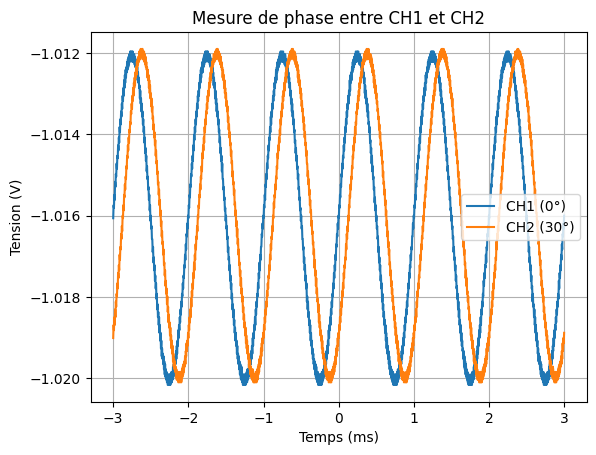

In [42]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

OSCI_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"

rm = pyvisa.ResourceManager()
scope = rm.open_resource(OSCI_ID)
scope.timeout = 5000
scope.encoding = "ascii"

print("IDN:", scope.query("*IDN?"))

# On fige l'acquisition pour avoir un signal stable
scope.write(":STOP")

# Configuration commune
scope.write(":WAV:FORM ASCII")
scope.write(":WAV:MODE NORM")

def read_waveform(channel: str):
    """Lit une waveform sur CHAN1 ou CHAN2 et renvoie (t, v) en unités physiques."""
    scope.write(f":WAV:SOUR {channel}")

    pre = scope.query(":WAV:PRE?").strip()
    p = pre.split(",")

    xinc  = float(p[4])
    xorig = float(p[5])
    xref  = float(p[6])
    yinc  = float(p[7])
    yorig = float(p[8])
    yref  = float(p[9])

    raw = scope.query(":WAV:DATA?")

    # Enlever l'en-tête #9xxxxxx si présent
    if raw.startswith("#"):
        nd = int(raw[1])                 # nombre de chiffres de la longueur
        nb = int(raw[2:2+nd])            # longueur des données
        start = 2 + nd
        raw = raw[start:start+nb]

    vals = [v for v in raw.split(",") if v.strip() != ""]
    adc = np.array([float(v) for v in vals])

    i = np.arange(adc.size)
    t = (i - xref) * xinc + xorig       # temps en secondes
    v = (adc - yref) * yinc + yorig     # tension en volts

    return t, v

# === Lecture des deux canaux ===
t1, v1 = read_waveform("CHAN1")
t2, v2 = read_waveform("CHAN2")

# On peut relancer l'oscillo en RUN après l'acquisition
scope.write(":RUN")
scope.close()
rm.close()

# On suppose que les deux ont la même base de temps
t = t1

# === Sélection d'une fenêtre commune autour de t = 0 ===
# (pour être sûr de prendre les deux pics dans la même période)
mask = (t > -0.0005) & (t < 0.0005)   # fenêtre de 1 ms centrée sur 0

t_cut  = t[mask]
v1_cut = v1[mask]
v2_cut = v2[mask]

# === Mesure du décalage temporel Δt dans cette fenêtre ===
i1 = np.argmax(v1_cut)
i2 = np.argmax(v2_cut)

t_peak1 = t_cut[i1]
t_peak2 = t_cut[i2]
dt = t_peak2 - t_peak1   # retard de CH2 par rapport à CH1

# Période théorique pour 1 kHz
f = 1000.0           # Hz
T = 1.0 / f          # s

phi_deg = (360.0 * dt / T) % 360   # ramène dans [0°, 360°]

print(f"t_peak1 = {t_peak1*1e6:.2f} µs")
print(f"t_peak2 = {t_peak2*1e6:.2f} µs")
print(f"Δt      = {dt*1e6:.2f} µs")
print(f"Phase mesurée ≈ {phi_deg:.2f}°  (phase générateur = 30°)")

# === Tracé pour visualiser ===
plt.figure()
plt.plot(t*1e3, v1, label="CH1 (0°)")
plt.plot(t*1e3, v2, label="CH2 (30°)")
plt.xlabel("Temps (ms)")
plt.ylabel("Tension (V)")
plt.title("Mesure de phase entre CH1 et CH2")
plt.grid()
plt.legend()
plt.show()



# Exo 5 :

Impossible de communiquer avec le générateur en SCPI.
Passe le DG1022 en manuel : SIN, 1 kHz, 1 Vpp, offset 0 V.
Détail erreur : VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.
SCOPE: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301111,00.04.04.SP4
Mesure : Vmin = -1.020 V, Vmax = -1.012 V, Vpp = 0.008 V


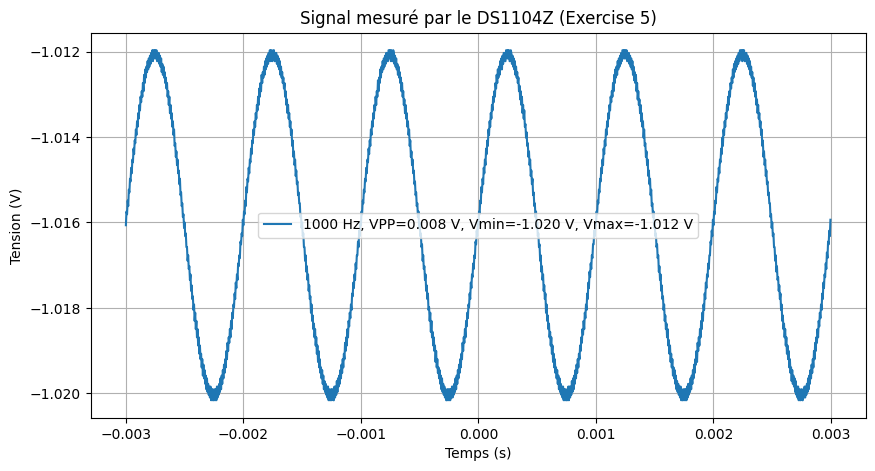

Fichier sauvegardé : exercise5_signal_20251211_143645.csv


In [44]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt
import csv
from datetime import datetime

# =============================
#  IDs VISA
# =============================
SCOPE_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"
GEN_ID   = "USB0::0x0400::0x09C4::DG1F143800623::INSTR"  # ton générateur

rm = pyvisa.ResourceManager()

# =============================
# 1) ESSAYER de parler au générateur
# =============================
freq = 1000.0     # Hz
vpp  = 2.0        # Vpp
offset = 0.0
phase = 0.0

generator_ok = False
try:
    gen = rm.open_resource(GEN_ID)
    gen.timeout = 2000
    gen.write_termination = "\n"
    gen.read_termination = "\n"

    idn_gen = gen.query("*IDN?")
    print("GEN:", idn_gen.strip())

    # Si ça répond, on configure le sinus automatiquement
    gen.write(":SOUR1:FUNC SIN")
    gen.write(f":SOUR1:FREQ {freq}")
    gen.write(f":SOUR1:VOLT {vpp}")
    gen.write(f":SOUR1:VOLT:OFFS {offset}")
    gen.write(f":SOUR1:PHAS {phase}")
    gen.write(":OUTP1 ON")

    generator_ok = True
    print("Signal généré automatiquement par SCPI.")
except Exception as e:
    print("Impossible de communiquer avec le générateur en SCPI.")
    print("Passe le DG1022 en manuel : SIN, 1 kHz, 1 Vpp, offset 0 V.")
    print("Détail erreur :", e)

# =============================
# 2) Connexion oscilloscope
# =============================
scope = rm.open_resource(SCOPE_ID)
scope.timeout = 5000
scope.encoding = "ascii"

print("SCOPE:", scope.query("*IDN?").strip())

scope.write(":STOP")
scope.write(":WAV:FORM ASCII")
scope.write(":WAV:MODE NORM")
scope.write(":WAV:SOUR CHAN1")

# =============================
# 3) Lecture préambule
# =============================
pre = scope.query(":WAV:PRE?").strip().split(",")

xinc  = float(pre[4])
xorig = float(pre[5])
xref  = float(pre[6])
yinc  = float(pre[7])
yorig = float(pre[8])
yref  = float(pre[9])

# =============================
# 4) Lecture données waveform
# =============================
raw = scope.query(":WAV:DATA?")

if raw.startswith("#"):
    nd = int(raw[1])
    nb = int(raw[2:2+nd])
    raw = raw[2+nd : 2+nd+nb]

data = np.array([float(v) for v in raw.split(",") if v.strip() != ""])

# =============================
# 5) Conversion en temps / tension
# =============================
i = np.arange(len(data))
t = (i - xref) * xinc + xorig
v = (data - yref) * yinc + yorig

Vmin = float(v.min())
Vmax = float(v.max())
Vpp_meas = Vmax - Vmin

print(f"Mesure : Vmin = {Vmin:.3f} V, Vmax = {Vmax:.3f} V, Vpp = {Vpp_meas:.3f} V")

# =============================
# 6) Tracé Matplotlib
# =============================
legend_txt = f"{freq:.0f} Hz, VPP={Vpp_meas:.3f} V, Vmin={Vmin:.3f} V, Vmax={Vmax:.3f} V"

plt.figure(figsize=(10, 5))
plt.plot(t, v, label=legend_txt)
plt.xlabel("Temps (s)")
plt.ylabel("Tension (V)")
plt.title("Signal mesuré par le DS1104Z (Exercise 5)")
plt.grid()
plt.legend()
plt.show()

# =============================
# 7) Sauvegarde CSV
# =============================
filename = "exercise5_signal_" + datetime.now().strftime("%Y%m%d_%H%M%S") + ".csv"

with open(filename, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["time_s", "voltage_v"])
    for ti, vi in zip(t, v):
        writer.writerow([ti, vi])

print("Fichier sauvegardé :", filename)

# =============================
# 8) Nettoyage
# =============================
scope.write(":RUN")
scope.close()

if generator_ok:
    gen.close()

rm.close()


SCOPE: RIGOL TECHNOLOGIES,DS1104Z Plus,DS1ZC212301111,00.04.04.SP4

=== CH1 (entrée) ===
Vmin = -26.519995
Vmax = -24.3199952
Vpp = 2.1999998000000005
Vrms = 25.435741675713654
T = 4.000000000000097e-06
f = 249999.99999999392

=== CH2 (sortie) ===
Vmin = -20.27999
Vmax = -20.27999
Vpp = 0.0
Vrms = 20.27999
T = 2.0000000000000486e-06
f = 499999.99999998783

Gain (Vpp_out / Vpp_in) = 0.000  (-inf dB)
Saturation CH1 ? False
Saturation CH2 ? False


C:\Users\yayal\AppData\Local\Temp\ipykernel_9632\1114830620.py:127: RuntimeWarning: divide by zero encountered in log10
  gain_db  = 20 * np.log10(abs(gain_lin))


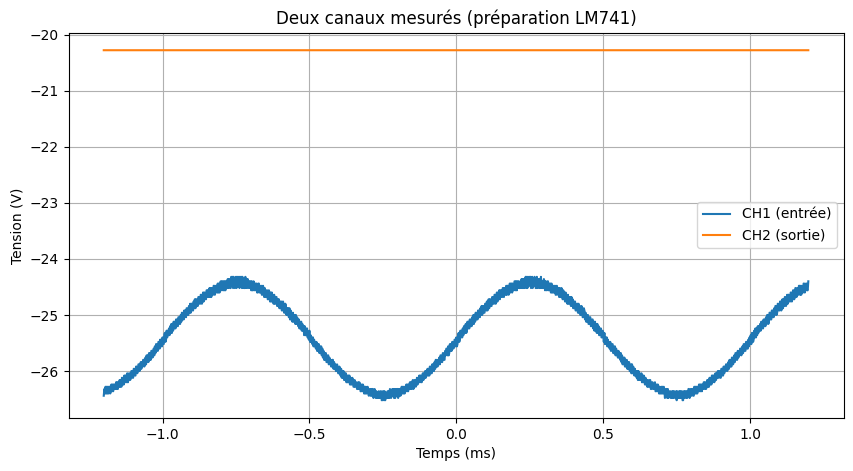

In [1]:
import pyvisa
import numpy as np
import matplotlib.pyplot as plt

SCOPE_ID = "USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR"

# ========= Fonctions utilitaires =========

def read_waveform(scope, channel: str):
    """
    Lit une waveform sur CHAN1 ou CHAN2 et renvoie (t, v) en secondes / volts.
    """
    scope.write(f":WAV:SOUR {channel}")
    pre = scope.query(":WAV:PRE?").strip().split(",")

    xinc  = float(pre[4])
    xorig = float(pre[5])
    xref  = float(pre[6])
    yinc  = float(pre[7])
    yorig = float(pre[8])
    yref  = float(pre[9])

    raw = scope.query(":WAV:DATA?")

    # En-tête #9xxxxx
    if raw.startswith("#"):
        nd = int(raw[1])
        nb = int(raw[2:2+nd])
        raw = raw[2+nd : 2+nd+nb]

    vals = [v for v in raw.split(",") if v.strip() != ""]
    adc = np.array([float(v) for v in vals])

    i = np.arange(adc.size)
    t = (i - xref) * xinc + xorig
    v = (adc - yref) * yinc + yorig

    return t, v

def compute_characteristics(t, v):
    """
    Renvoie un dict avec Vmin, Vmax, Vpp, Vrms, fréquence estimée.
    """
    Vmin = float(v.min())
    Vmax = float(v.max())
    Vpp  = Vmax - Vmin
    Vrms = float(np.sqrt(np.mean(v**2)))

    # Estimation de la période : distance entre 2 maxima successifs
    # (tu peux raffiner avec zero-crossings plus tard)
    i1 = np.argmax(v)
    # rechercher le max suivant après i1
    if i1 + 1 < len(v) - 1:
        i2_rel = np.argmax(v[i1+1:])      # index relatif
        i2 = i1 + 1 + i2_rel              # index absolu
        T_est = t[i2] - t[i1]
        f_est = 1.0 / T_est if T_est > 0 else float("nan")
    else:
        T_est = float("nan")
        f_est = float("nan")

    return {
        "Vmin": Vmin,
        "Vmax": Vmax,
        "Vpp": Vpp,
        "Vrms": Vrms,
        "T": T_est,
        "f": f_est,
    }

def detect_saturation(v, threshold_ratio=0.95):
    """
    Détection très simple de saturation/clipping :
    si beaucoup d'échantillons sont très proches de Vmax ou Vmin.
    """
    Vmin = v.min()
    Vmax = v.max()
    amp = (Vmax - Vmin) / 2
    if amp == 0:
        return False

    upper_level = Vmin + threshold_ratio * (Vmax - Vmin)
    lower_level = Vmin + (1 - threshold_ratio) * (Vmax - Vmin)

    frac_high = np.mean(v >= upper_level)
    frac_low  = np.mean(v <= lower_level)

    # si plus de 10% des points sont "collés" en haut ou en bas → clipping probable
    return (frac_high > 0.1) or (frac_low > 0.1)

# ========= Programme principal =========

rm = pyvisa.ResourceManager()
scope = rm.open_resource(SCOPE_ID)
scope.timeout = 5000
scope.encoding = "ascii"

print("SCOPE:", scope.query("*IDN?").strip())

# Geler l'affichage pour une acquisition stable
scope.write(":STOP")
scope.write(":WAV:FORM ASCII")
scope.write(":WAV:MODE NORM")

# ----- Lire CH1 et CH2 -----
t1, v1 = read_waveform(scope, "CHAN1")
t2, v2 = read_waveform(scope, "CHAN2")

# On suppose même base de temps
t = t1

# ----- Caractéristiques -----
car1 = compute_characteristics(t1, v1)
car2 = compute_characteristics(t2, v2)

print("\n=== CH1 (entrée) ===")
for k, val in car1.items():
    print(f"{k} = {val}")

print("\n=== CH2 (sortie) ===")
for k, val in car2.items():
    print(f"{k} = {val}")

# Gain pour un futur LM741
if car1["Vpp"] > 0:
    gain_lin = car2["Vpp"] / car1["Vpp"]
    gain_db  = 20 * np.log10(abs(gain_lin))
else:
    gain_lin = float("nan")
    gain_db = float("nan")

print(f"\nGain (Vpp_out / Vpp_in) = {gain_lin:.3f}  ({gain_db:.2f} dB)")

# Détection saturation
sat1 = detect_saturation(v1)
sat2 = detect_saturation(v2)
print(f"Saturation CH1 ? {sat1}")
print(f"Saturation CH2 ? {sat2}")

# ----- Tracé -----
plt.figure(figsize=(10,5))
plt.plot(t*1e3, v1, label="CH1 (entrée)")
plt.plot(t*1e3, v2, label="CH2 (sortie)")
plt.xlabel("Temps (ms)")
plt.ylabel("Tension (V)")
plt.title("Deux canaux mesurés (préparation LM741)")
plt.grid()
plt.legend()
plt.show()

# Remettre en RUN
scope.write(":RUN")
scope.close()
rm.close()


In [55]:
import pyvisa

rm = pyvisa.ResourceManager()
gen = rm.open_resource("USB0::0x0400::0x09C4::DG1F143800623::INSTR")

gen.timeout = 3000
gen.write_termination = "\n"
gen.read_termination = "\n"

try:
    print("GEN ID:", gen.query("*IDN?"))
except Exception as e:
    print("Erreur IDN:", e)

gen.close()
rm.close()


rm = pyvisa.ResourceManager()       # sans '@py' car on uutlise NI-VISA
ID=rm.list_resources()
print("generateur:",ID)


Erreur IDN: VI_ERROR_TMO (-1073807339): Timeout expired before operation completed.
generateur: ('USB0::0x1AB1::0x04CE::DS1ZC212301111::INSTR', 'USB0::0x0400::0x09C4::DG1F143800623::INSTR', 'ASRL7::INSTR', 'ASRL8::INSTR')
